In [1]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import dump, load
import os
import requests
import datetime
import json
import yfinance as yf
%matplotlib inline
warnings.filterwarnings('ignore')

---

## S&P 500 ETF

In [2]:
tickers = ['SPY']

data = yf.download(tickers, '2016-01-01')
data.fillna(method='ffill', inplace=True)
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-06,316.369995,317.679993,315.559998,317.049988,317.049988,61713800
2020-07-07,315.380005,317.519989,313.369995,313.779999,313.779999,82910000
2020-07-08,314.609985,316.299988,312.700012,316.179993,316.179993,54638600
2020-07-09,316.839996,317.100006,310.679993,314.380005,314.380005,83354200
2020-07-10,314.309998,317.880005,312.760010,317.589996,317.589996,57461900


In [3]:
data['Daily_Return'] = data['Close'].dropna().pct_change()
data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return
Date,,,,,,,
2016-01-04,200.490005,201.029999,198.589996,201.020004,184.025345,222353500,NaN
2016-01-05,201.399994,201.899994,200.050003,201.360001,184.336609,110845800,0.001691
2016-01-06,198.339996,200.059998,197.600006,198.820007,182.011322,152112600,-0.012614
2016-01-07,195.330002,197.440002,193.589996,194.050003,177.644592,213436100,-0.023992
2016-01-08,195.190002,195.850006,191.580002,191.919998,175.694717,209817200,-0.010977
2016-01-11,193.009995,193.410004,189.820007,192.110001,175.868607,187941300,0.000990
2016-01-12,193.820007,194.550003,191.139999,193.660004,177.287598,172330500,0.008068
2016-01-13,194.449997,194.860001,188.380005,188.830002,172.865936,221168900,-0.024941
2016-01-14,189.550003,193.259995,187.660004,191.929993,175.703857,240795600,0.016417


In [4]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,,
2016-01-04,200.490005,201.029999,198.589996,201.020004,184.025345,222353500,NaN,201.020004,201.020004,0.0,0.0,0.0
2016-01-05,201.399994,201.899994,200.050003,201.360001,184.336609,110845800,0.001691,201.246668,201.195892,1.0,0.0,1.0
2016-01-06,198.339996,200.059998,197.600006,198.820007,182.011322,152112600,-0.012614,199.860005,200.348446,0.0,-1.0,-1.0
2016-01-07,195.330002,197.440002,193.589996,194.050003,177.644592,213436100,-0.023992,196.761337,198.606541,0.0,-1.0,-1.0
2016-01-08,195.190002,195.850006,191.580002,191.919998,175.694717,209817200,-0.010977,194.262582,197.077732,0.0,-1.0,-1.0


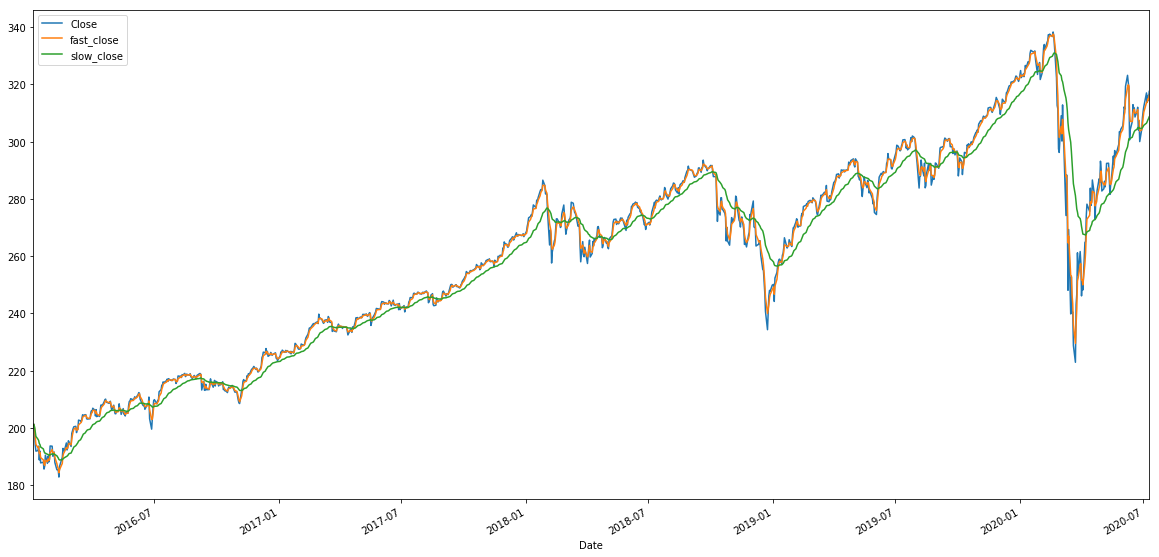

In [5]:
# Plot the EMA of BTC/USD closing prices
data[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [6]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily_Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily_Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,,
2016-01-04,200.490005,201.029999,198.589996,201.020004,184.025345,222353500,NaN,201.020004,201.020004,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2016-01-05,201.399994,201.899994,200.050003,201.360001,184.336609,110845800,0.001691,201.246668,201.195892,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
2016-01-06,198.339996,200.059998,197.600006,198.820007,182.011322,152112600,-0.012614,199.860005,200.348446,0.0,-1.0,-1.0,0.010116,0.010116,0.0,0.0,0.0
2016-01-07,195.330002,197.440002,193.589996,194.050003,177.644592,213436100,-0.023992,196.761337,198.606541,0.0,-1.0,-1.0,0.012076,0.012830,1.0,0.0,1.0
2016-01-08,195.190002,195.850006,191.580002,191.919998,175.694717,209817200,-0.010977,194.262582,197.077732,0.0,-1.0,-1.0,0.008795,0.010311,1.0,0.0,1.0
2016-01-11,193.009995,193.410004,189.820007,192.110001,175.868607,187941300,0.000990,193.169207,196.099986,0.0,-1.0,-1.0,0.011001,0.010656,0.0,-1.0,-1.0
2016-01-12,193.820007,194.550003,191.139999,193.660004,177.287598,172330500,0.008068,193.416538,195.674943,0.0,-1.0,-1.0,0.011656,0.011942,1.0,0.0,1.0
2016-01-13,194.449997,194.860001,188.380005,188.830002,172.865936,221168900,-0.024941,191.114277,194.598039,0.0,-1.0,-1.0,0.017954,0.013326,0.0,-1.0,-1.0
2016-01-14,189.550003,193.259995,187.660004,191.929993,175.703857,240795600,0.016417,191.522933,194.213066,0.0,-1.0,-1.0,0.021560,0.015639,0.0,-1.0,-1.0


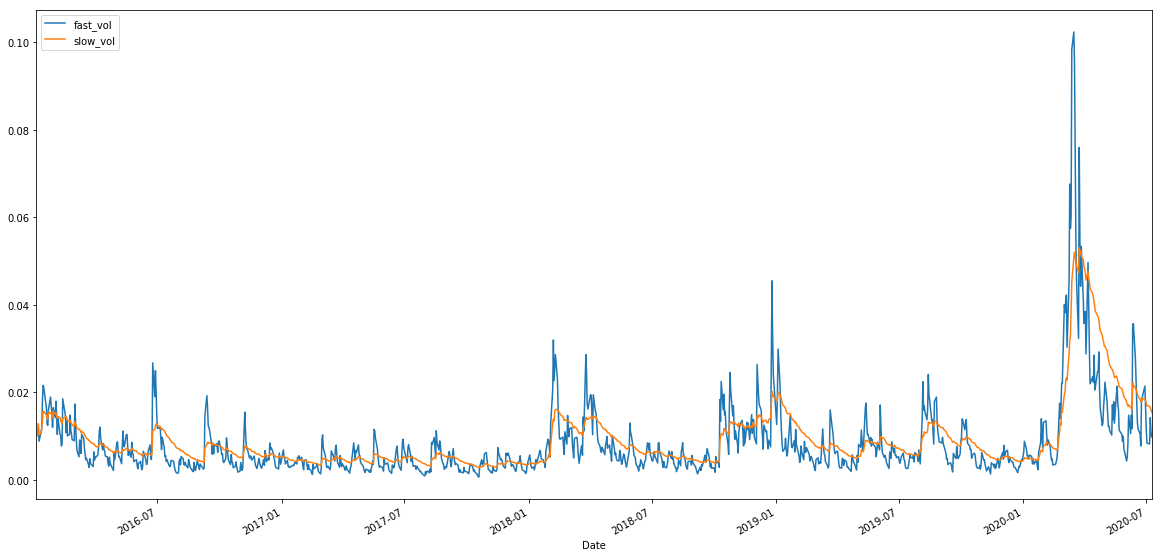

In [7]:
# Plot the EMA of BTC/USD daily return volatility
data[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [8]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,200.490005,201.029999,198.589996,201.020004,184.025345,222353500,NaN,201.020004,201.020004,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-05,201.399994,201.899994,200.050003,201.360001,184.336609,110845800,0.001691,201.246668,201.195892,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-06,198.339996,200.059998,197.600006,198.820007,182.011322,152112600,-0.012614,199.860005,200.348446,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-07,195.330002,197.440002,193.589996,194.050003,177.644592,213436100,-0.023992,196.761337,198.606541,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-08,195.190002,195.850006,191.580002,191.919998,175.694717,209817200,-0.010977,194.262582,197.077732,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-11,193.009995,193.410004,189.820007,192.110001,175.868607,187941300,0.000990,193.169207,196.099986,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-12,193.820007,194.550003,191.139999,193.660004,177.287598,172330500,0.008068,193.416538,195.674943,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-13,194.449997,194.860001,188.380005,188.830002,172.865936,221168900,-0.024941,191.114277,194.598039,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-14,189.550003,193.259995,187.660004,191.929993,175.703857,240795600,0.016417,191.522933,194.213066,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


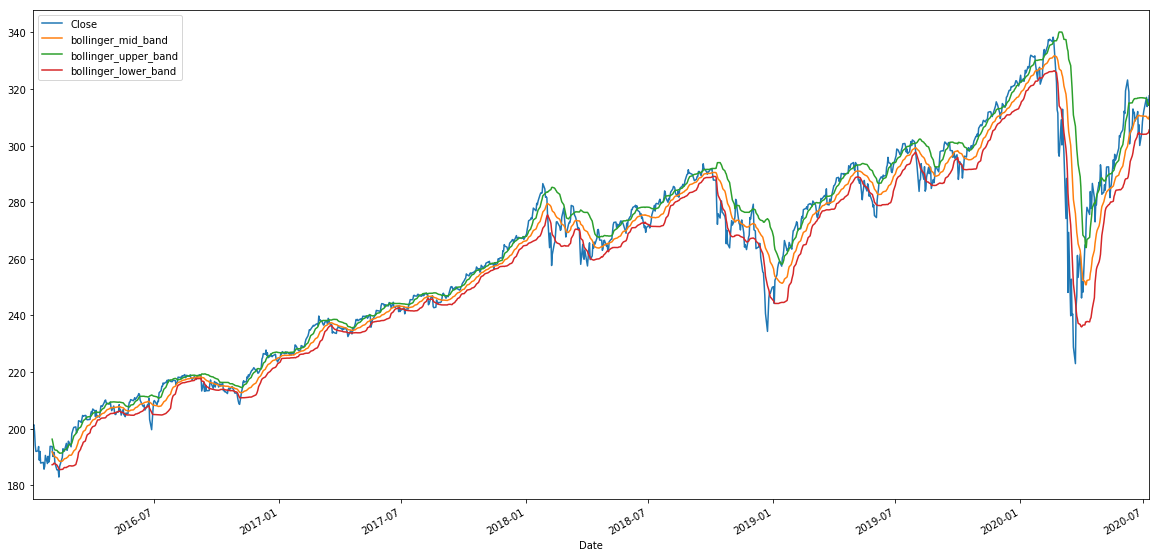

In [9]:
# Plot the Bollinger Bands for BTC/USD closing prices
data[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [10]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-07-06,1.0,1.0,-1.0
2020-07-07,1.0,1.0,0.0
2020-07-08,1.0,1.0,-1.0
2020-07-09,1.0,1.0,-1.0
2020-07-10,1.0,1.0,-1.0


In [11]:
# Shift DataFrame values by 1
data[x_var_list] = data[x_var_list].shift(1)
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-07-06,1.0,1.0,0.0
2020-07-07,1.0,1.0,-1.0
2020-07-08,1.0,1.0,0.0
2020-07-09,1.0,1.0,-1.0
2020-07-10,1.0,1.0,-1.0


In [12]:
# Drop NAs and replace positive/negative infinity values
data.dropna(subset=x_var_list, inplace=True)
data.dropna(subset=['Daily_Return'], inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,201.399994,201.899994,200.050003,201.360001,184.336609,110845800,0.001691,201.246668,201.195892,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-06,198.339996,200.059998,197.600006,198.820007,182.011322,152112600,-0.012614,199.860005,200.348446,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-07,195.330002,197.440002,193.589996,194.050003,177.644592,213436100,-0.023992,196.761337,198.606541,0.0,...,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-08,195.190002,195.850006,191.580002,191.919998,175.694717,209817200,-0.010977,194.262582,197.077732,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-11,193.009995,193.410004,189.820007,192.110001,175.868607,187941300,0.000990,193.169207,196.099986,0.0,...,0.0,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [13]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
data['Positive Return'] = np.where(data['Daily_Return'] > 0, 1.0, 0.0)
data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,201.399994,201.899994,200.050003,201.360001,184.336609,110845800,0.001691,201.246668,201.195892,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-06,198.339996,200.059998,197.600006,198.820007,182.011322,152112600,-0.012614,199.860005,200.348446,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-07,195.330002,197.440002,193.589996,194.050003,177.644592,213436100,-0.023992,196.761337,198.606541,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-08,195.190002,195.850006,191.580002,191.919998,175.694717,209817200,-0.010977,194.262582,197.077732,0.0,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-11,193.009995,193.410004,189.820007,192.110001,175.868607,187941300,0.000990,193.169207,196.099986,0.0,...,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-12,193.820007,194.550003,191.139999,193.660004,177.287598,172330500,0.008068,193.416538,195.674943,0.0,...,0.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-13,194.449997,194.860001,188.380005,188.830002,172.865936,221168900,-0.024941,191.114277,194.598039,0.0,...,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-14,189.550003,193.259995,187.660004,191.929993,175.703857,240795600,0.016417,191.522933,194.213066,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-15,186.770004,188.759995,185.520004,187.809998,171.932159,324846400,-0.021466,189.664650,193.355477,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [14]:
# Construct training start and end dates
training_start = data.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-04-30'

# Construct testing start and end dates
testing_start =  '2020-05-01'
testing_end = data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2016-01-05
Training End: 2020-04-30
Testing Start: 2020-05-01
Testing End: 2020-07-10


In [15]:
# Construct the X_train and y_train datasets
X_train = data[x_var_list][training_start:training_end]
y_train = data['Positive Return'][training_start:training_end]

X_train.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-04-24,1.0,1.0,0.0
2020-04-27,1.0,1.0,-1.0
2020-04-28,1.0,1.0,-1.0
2020-04-29,1.0,1.0,0.0
2020-04-30,1.0,1.0,-1.0


In [16]:
y_train.tail()

Date
2020-04-24    1.0
2020-04-27    1.0
2020-04-28    0.0
2020-04-29    1.0
2020-04-30    0.0
Name: Positive Return, dtype: float64

In [17]:
# Construct the X test and y test datasets
X_test = data[x_var_list][testing_start:testing_end]
y_test = data['Positive Return'][testing_start:testing_end]

X_test.head()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-05-01,1.0,1.0,-1.0
2020-05-04,1.0,1.0,0.0
2020-05-05,1.0,1.0,0.0
2020-05-06,1.0,1.0,0.0
2020-05-07,1.0,1.0,0.0


In [18]:
y_test.tail()

Date
2020-07-06    1.0
2020-07-07    0.0
2020-07-08    1.0
2020-07-09    0.0
2020-07-10    1.0
Name: Positive Return, dtype: float64

In [19]:
rfc = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,150,200,250],
    "max_depth":[1,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,None]    
}

In [20]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [21]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [22]:
display(cv)

Best parameters are: {'max_depth': 2, 'n_estimators': 5}


0.552 + or -0.002 for the {'max_depth': 1, 'n_estimators': 5}
0.552 + or -0.002 for the {'max_depth': 1, 'n_estimators': 10}
0.552 + or -0.002 for the {'max_depth': 1, 'n_estimators': 50}
0.552 + or -0.002 for the {'max_depth': 1, 'n_estimators': 100}
0.552 + or -0.002 for the {'max_depth': 1, 'n_estimators': 150}
0.552 + or -0.002 for the {'max_depth': 1, 'n_estimators': 200}
0.552 + or -0.002 for the {'max_depth': 1, 'n_estimators': 250}
0.555 + or -0.009 for the {'max_depth': 2, 'n_estimators': 5}
0.542 + or -0.009 for the {'max_depth': 2, 'n_estimators': 10}
0.544 + or -0.015 for the {'max_depth': 2, 'n_estimators': 50}
0.541 + or -0.015 for the {'max_depth': 2, 'n_estimators': 100}
0.541 + or -0.015 for the {'max_depth': 2, 'n_estimators': 150}
0.541 + or -0.015 for the {'max_depth': 2, 'n_estimators': 200}
0.541 + or -0.015 for the {'max_depth': 2, 'n_estimators': 250}
0.531 + or -0.037 for the {'max_depth': 4, 'n_estimat

In [23]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=5, max_depth=1, random_state=0)

model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,0.0,1.0
2020-05-04,1.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,1.0
2020-05-08,1.0,1.0
2020-05-11,1.0,1.0
2020-05-12,0.0,1.0
2020-05-13,0.0,1.0


In [24]:
# make the predictions from the X_test dataset
predictions = model.predict(X_test)
predictions

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
# Y test data predicted
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,0.0,1.0
2020-05-04,1.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,1.0
2020-05-08,1.0,1.0
2020-05-11,1.0,1.0
2020-05-12,0.0,1.0
2020-05-13,0.0,1.0


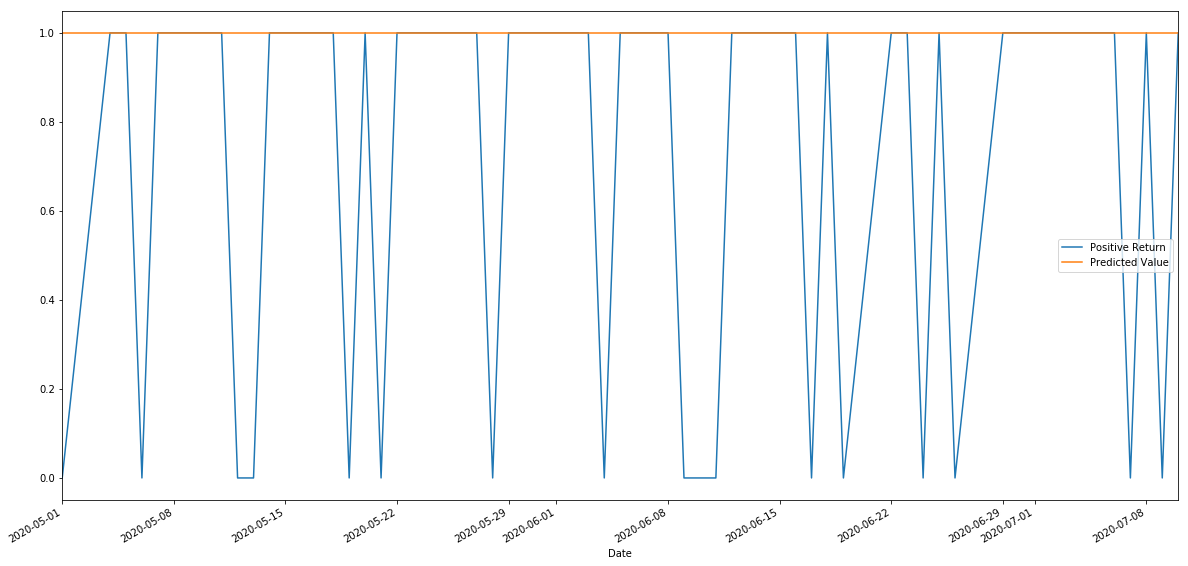

In [26]:
# Plot predicted results vs. actual results
Results[['Positive Return', 'Predicted Value']].plot(figsize=(20,10))

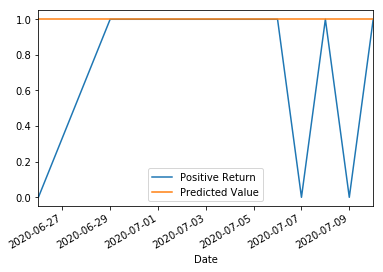

In [27]:
Results[['Positive Return', 'Predicted Value']].tail(10).plot()

In [28]:
Results['Predicted Value'].replace(0, -1, inplace=True)
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,0.0,1.0
2020-05-04,1.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,1.0
2020-05-08,1.0,1.0
2020-05-11,1.0,1.0
2020-05-12,0.0,1.0
2020-05-13,0.0,1.0


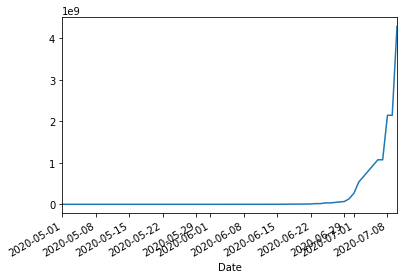

In [29]:
(1 + (Results['Positive Return'] * Results['Predicted Value'])).cumprod().plot()

In [30]:
# Calculating the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)



In [35]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Accuracy Score : 0.6530612244897959
Classification Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        17
         1.0       0.65      1.00      0.79        32

    accuracy                           0.65        49
   macro avg       0.33      0.50      0.40        49
weighted avg       0.43      0.65      0.52        49



---

## Gold ETF Price

In [36]:
tickers = ['GLD']

data = yf.download(tickers, '2016-01-01')
data.fillna(method='ffill', inplace=True)
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-06,167.750000,168.000000,167.190002,167.979996,167.979996,7265700
2020-07-07,167.410004,169.039993,167.380005,169.039993,169.039993,11633100
2020-07-08,170.320007,170.860001,169.779999,170.089996,170.089996,11662700
2020-07-09,170.479996,170.639999,168.779999,169.630005,169.630005,13327400
2020-07-10,169.949997,170.149994,168.570007,169.190002,169.190002,8214800


In [37]:
data['Daily_Return'] = data['Close'].dropna().pct_change()
data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return
Date,,,,,,,
2016-01-04,103.129997,103.669998,102.489998,102.889999,102.889999,6440000,NaN
2016-01-05,103.129997,103.459999,102.930000,103.180000,103.180000,3500300,0.002819
2016-01-06,104.370003,104.800003,103.930000,104.669998,104.669998,9316600,0.014441
2016-01-07,105.830002,106.239998,105.190002,106.150002,106.150002,11730400,0.014140
2016-01-08,105.480003,105.800003,105.040001,105.680000,105.680000,7678200,-0.004428
2016-01-11,105.470001,105.570000,104.709999,104.739998,104.739998,6272400,-0.008895
2016-01-12,104.089996,104.589996,103.650002,104.209999,104.209999,5540200,-0.005060
2016-01-13,103.889999,104.820000,103.779999,104.720001,104.720001,7324200,0.004894
2016-01-14,103.750000,104.180000,102.500000,103.019997,103.019997,9989100,-0.016234


In [38]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,,,,,,
2016-01-04,103.129997,103.669998,102.489998,102.889999,102.889999,6440000,NaN,102.889999,102.889999,0.0,0.0,0.0
2016-01-05,103.129997,103.459999,102.930000,103.180000,103.180000,3500300,0.002819,103.083333,103.040023,1.0,0.0,1.0
2016-01-06,104.370003,104.800003,103.930000,104.669998,104.669998,9316600,0.014441,103.989999,103.621413,1.0,0.0,1.0
2016-01-07,105.830002,106.239998,105.190002,106.150002,106.150002,11730400,0.014140,105.142000,104.320723,1.0,0.0,1.0
2016-01-08,105.480003,105.800003,105.040001,105.680000,105.680000,7678200,-0.004428,105.419678,104.631507,1.0,0.0,1.0


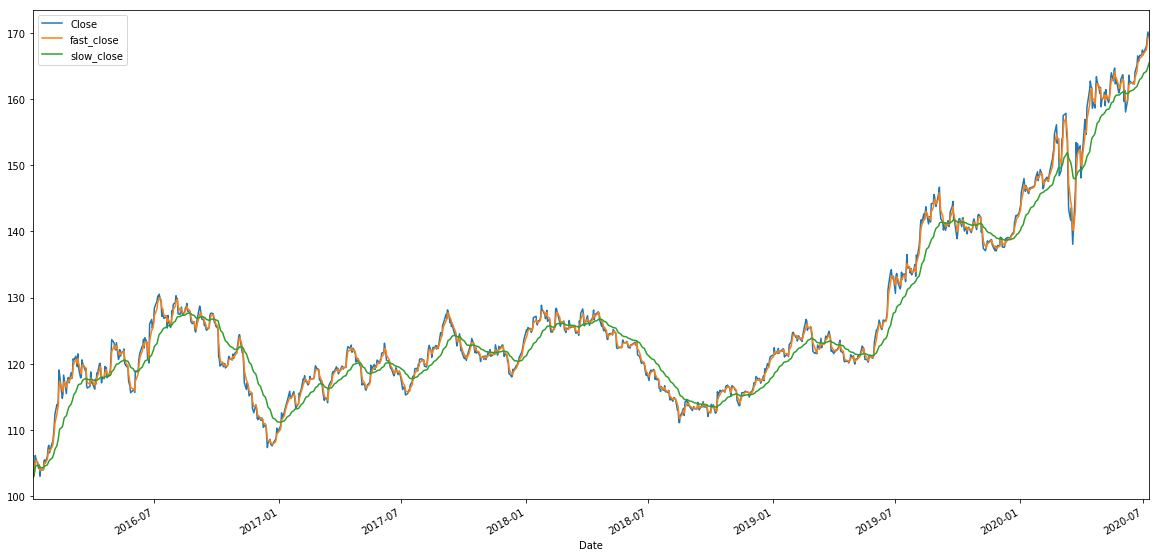

In [39]:
# Plot the EMA of BTC/USD closing prices
data[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [40]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily_Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily_Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,,,,,,
2016-01-04,103.129997,103.669998,102.489998,102.889999,102.889999,6440000,NaN,102.889999,102.889999,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2016-01-05,103.129997,103.459999,102.930000,103.180000,103.180000,3500300,0.002819,103.083333,103.040023,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
2016-01-06,104.370003,104.800003,103.930000,104.669998,104.669998,9316600,0.014441,103.989999,103.621413,1.0,0.0,1.0,0.008218,0.008218,0.0,0.0,0.0
2016-01-07,105.830002,106.239998,105.190002,106.150002,106.150002,11730400,0.014140,105.142000,104.320723,1.0,0.0,1.0,0.005290,0.006505,1.0,0.0,1.0
2016-01-08,105.480003,105.800003,105.040001,105.680000,105.680000,7678200,-0.004428,105.419678,104.631507,1.0,0.0,1.0,0.011317,0.009412,0.0,-1.0,-1.0
2016-01-11,105.470001,105.570000,104.709999,104.739998,104.739998,6272400,-0.008895,105.074444,104.652860,1.0,0.0,1.0,0.010930,0.010803,0.0,-1.0,-1.0
2016-01-12,104.089996,104.589996,103.650002,104.209999,104.209999,5540200,-0.005060,104.638818,104.575714,1.0,0.0,1.0,0.007720,0.010119,1.0,0.0,1.0
2016-01-13,103.889999,104.820000,103.779999,104.720001,104.720001,7324200,0.004894,104.679569,104.598415,1.0,0.0,1.0,0.007692,0.009180,1.0,0.0,1.0
2016-01-14,103.750000,104.180000,102.500000,103.019997,103.019997,9989100,-0.016234,103.848159,104.370664,0.0,-1.0,-1.0,0.011602,0.010967,0.0,-1.0,-1.0


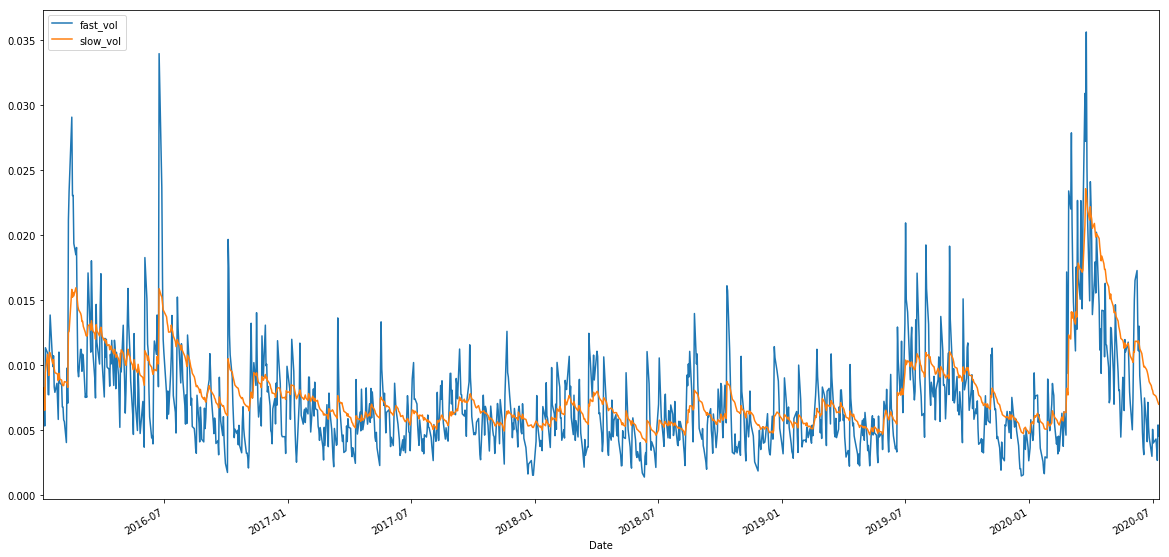

In [41]:
# Plot the EMA of BTC/USD daily return volatility
data[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

In [42]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,103.129997,103.669998,102.489998,102.889999,102.889999,6440000,NaN,102.889999,102.889999,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-05,103.129997,103.459999,102.930000,103.180000,103.180000,3500300,0.002819,103.083333,103.040023,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-06,104.370003,104.800003,103.930000,104.669998,104.669998,9316600,0.014441,103.989999,103.621413,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-07,105.830002,106.239998,105.190002,106.150002,106.150002,11730400,0.014140,105.142000,104.320723,1.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-08,105.480003,105.800003,105.040001,105.680000,105.680000,7678200,-0.004428,105.419678,104.631507,1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-11,105.470001,105.570000,104.709999,104.739998,104.739998,6272400,-0.008895,105.074444,104.652860,1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-12,104.089996,104.589996,103.650002,104.209999,104.209999,5540200,-0.005060,104.638818,104.575714,1.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-13,103.889999,104.820000,103.779999,104.720001,104.720001,7324200,0.004894,104.679569,104.598415,1.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-14,103.750000,104.180000,102.500000,103.019997,103.019997,9989100,-0.016234,103.848159,104.370664,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


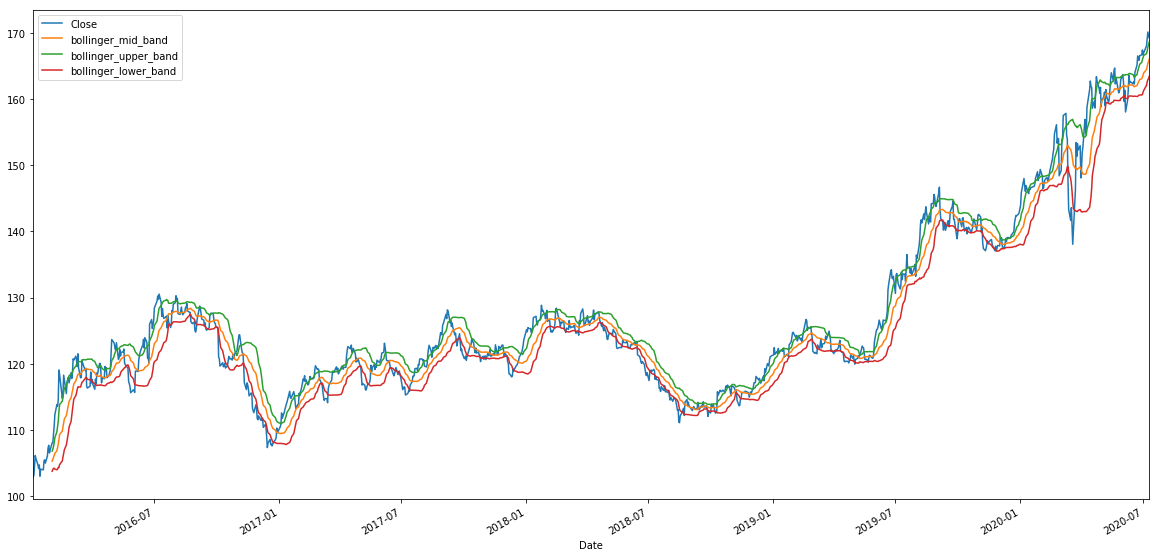

In [43]:
# Plot the Bollinger Bands for BTC/USD closing prices
data[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [44]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-07-06,1.0,1.0,-1.0
2020-07-07,1.0,1.0,-1.0
2020-07-08,1.0,1.0,-1.0
2020-07-09,1.0,1.0,-1.0
2020-07-10,1.0,1.0,-1.0


In [45]:
# Shift DataFrame values by 1
data[x_var_list] = data[x_var_list].shift(1)
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-07-06,1.0,1.0,-1.0
2020-07-07,1.0,1.0,-1.0
2020-07-08,1.0,1.0,-1.0
2020-07-09,1.0,1.0,-1.0
2020-07-10,1.0,1.0,-1.0


In [46]:
# Drop NAs and replace positive/negative infinity values
data.dropna(subset=x_var_list, inplace=True)
data.dropna(subset=['Daily_Return'], inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,103.129997,103.459999,102.930000,103.180000,103.180000,3500300,0.002819,103.083333,103.040023,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-06,104.370003,104.800003,103.930000,104.669998,104.669998,9316600,0.014441,103.989999,103.621413,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-07,105.830002,106.239998,105.190002,106.150002,106.150002,11730400,0.014140,105.142000,104.320723,1.0,...,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-08,105.480003,105.800003,105.040001,105.680000,105.680000,7678200,-0.004428,105.419678,104.631507,1.0,...,0.0,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2016-01-11,105.470001,105.570000,104.709999,104.739998,104.739998,6272400,-0.008895,105.074444,104.652860,1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [47]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
data['Positive Return'] = np.where(data['Daily_Return'] > 0, 1.0, 0.0)
data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,fast_close,slow_close,crossover_long,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,103.129997,103.459999,102.930000,103.180000,103.180000,3500300,0.002819,103.083333,103.040023,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-06,104.370003,104.800003,103.930000,104.669998,104.669998,9316600,0.014441,103.989999,103.621413,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-07,105.830002,106.239998,105.190002,106.150002,106.150002,11730400,0.014140,105.142000,104.320723,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-08,105.480003,105.800003,105.040001,105.680000,105.680000,7678200,-0.004428,105.419678,104.631507,1.0,...,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-11,105.470001,105.570000,104.709999,104.739998,104.739998,6272400,-0.008895,105.074444,104.652860,1.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-12,104.089996,104.589996,103.650002,104.209999,104.209999,5540200,-0.005060,104.638818,104.575714,1.0,...,0.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-13,103.889999,104.820000,103.779999,104.720001,104.720001,7324200,0.004894,104.679569,104.598415,1.0,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
2016-01-14,103.750000,104.180000,102.500000,103.019997,103.019997,9989100,-0.016234,103.848159,104.370664,0.0,...,-1.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2016-01-15,104.919998,104.959999,103.970001,104.080002,104.080002,10052700,0.010289,103.964194,104.331735,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0


In [48]:
# Construct training start and end dates
training_start = data.index.min().strftime(format= '%Y-%m-%d')
training_end = '2020-04-30'

# Construct testing start and end dates
testing_start =  '2020-05-01'
testing_end = data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2016-01-05
Training End: 2020-04-30
Testing Start: 2020-05-01
Testing End: 2020-07-10


In [49]:
# Construct the X_train and y_train datasets
X_train = data[x_var_list][training_start:training_end]
y_train = data['Positive Return'][training_start:training_end]

X_train.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-04-24,1.0,1.0,-1.0
2020-04-27,1.0,1.0,-1.0
2020-04-28,1.0,1.0,0.0
2020-04-29,1.0,1.0,0.0
2020-04-30,1.0,1.0,0.0


In [50]:
y_train.tail()

Date
2020-04-24    0.0
2020-04-27    0.0
2020-04-28    0.0
2020-04-29    1.0
2020-04-30    0.0
Name: Positive Return, dtype: float64

In [51]:
# Construct the X test and y test datasets
X_test = data[x_var_list][testing_start:testing_end]
y_test = data['Positive Return'][testing_start:testing_end]

X_test.head()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-05-01,1.0,1.0,0.0
2020-05-04,1.0,1.0,0.0
2020-05-05,1.0,1.0,0.0
2020-05-06,1.0,1.0,0.0
2020-05-07,1.0,1.0,0.0


In [52]:
y_test.tail()

Date
2020-07-06    1.0
2020-07-07    1.0
2020-07-08    1.0
2020-07-09    0.0
2020-07-10    0.0
Name: Positive Return, dtype: float64

In [53]:
rfc = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,150,200,250],
    "max_depth":[1,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,None]    
}

In [54]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [55]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [56]:
display(cv)

Best parameters are: {'max_depth': 2, 'n_estimators': 150}


0.536 + or -0.002 for the {'max_depth': 1, 'n_estimators': 5}
0.537 + or -0.001 for the {'max_depth': 1, 'n_estimators': 10}
0.537 + or -0.001 for the {'max_depth': 1, 'n_estimators': 50}
0.537 + or -0.001 for the {'max_depth': 1, 'n_estimators': 100}
0.537 + or -0.001 for the {'max_depth': 1, 'n_estimators': 150}
0.537 + or -0.001 for the {'max_depth': 1, 'n_estimators': 200}
0.537 + or -0.001 for the {'max_depth': 1, 'n_estimators': 250}
0.534 + or -0.012 for the {'max_depth': 2, 'n_estimators': 5}
0.537 + or -0.017 for the {'max_depth': 2, 'n_estimators': 10}
0.53 + or -0.01 for the {'max_depth': 2, 'n_estimators': 50}
0.54 + or -0.013 for the {'max_depth': 2, 'n_estimators': 100}
0.544 + or -0.015 for the {'max_depth': 2, 'n_estimators': 150}
0.54 + or -0.013 for the {'max_depth': 2, 'n_estimators': 200}
0.54 + or -0.013 for the {'max_depth': 2, 'n_estimators': 250}
0.528 + or -0.029 for the {'max_depth': 4, 'n_estimators

In [57]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,1.0,1.0
2020-05-04,1.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,1.0
2020-05-08,0.0,1.0
2020-05-11,0.0,1.0
2020-05-12,1.0,1.0
2020-05-13,1.0,1.0


In [58]:
# make the predictions from the X_test dataset
predictions = model.predict(X_test)
predictions

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [59]:
# Y test data predicted
Results["Predicted Value"] = predictions
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,1.0,1.0
2020-05-04,1.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,1.0
2020-05-08,0.0,1.0
2020-05-11,0.0,1.0
2020-05-12,1.0,1.0
2020-05-13,1.0,1.0


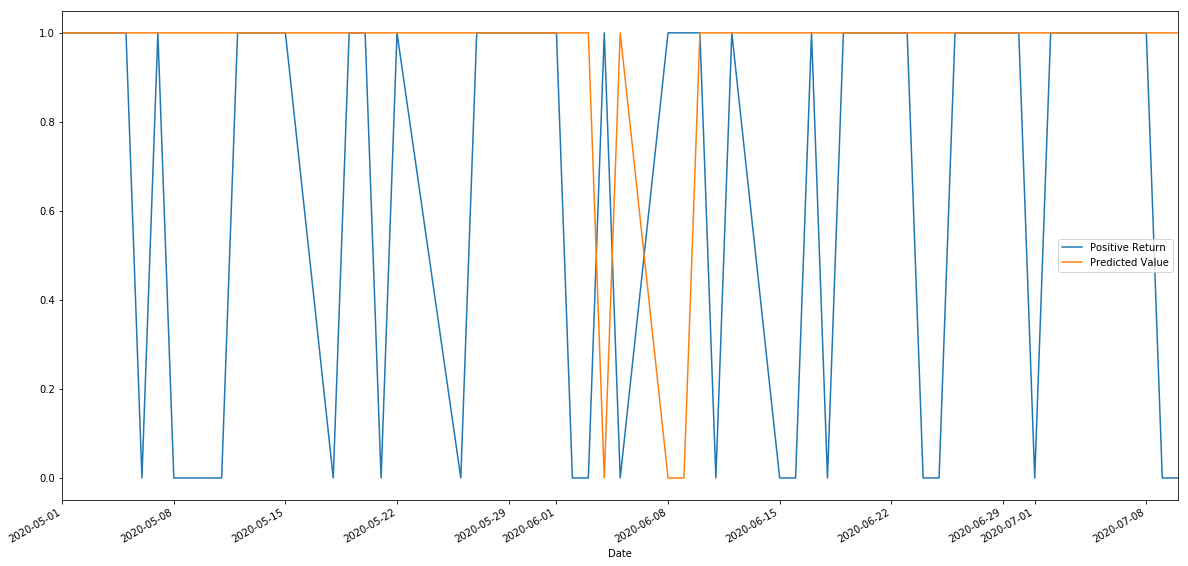

In [60]:
# Plot predicted results vs. actual results
Results[['Positive Return', 'Predicted Value']].plot(figsize=(20,10))

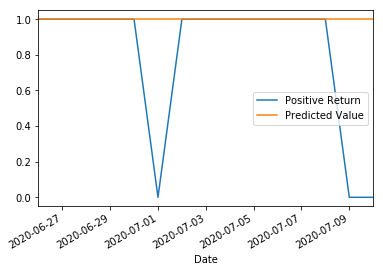

In [61]:
Results[['Positive Return', 'Predicted Value']].tail(10).plot()

In [62]:
Results['Predicted Value'].replace(0, -1, inplace=True)
Results

,Positive Return,Predicted Value
Date,,
2020-05-01,1.0,1.0
2020-05-04,1.0,1.0
2020-05-05,1.0,1.0
2020-05-06,0.0,1.0
2020-05-07,1.0,1.0
2020-05-08,0.0,1.0
2020-05-11,0.0,1.0
2020-05-12,1.0,1.0
2020-05-13,1.0,1.0


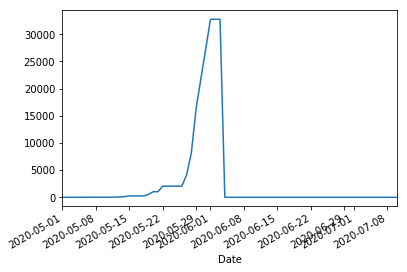

In [63]:
(1 + (Results['Positive Return'] * Results['Predicted Value'])).cumprod().plot()

In [64]:
# Calculating the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [65]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Accuracy Score : 0.5714285714285714
Classification Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.61      0.90      0.73        31

    accuracy                           0.57        49
   macro avg       0.30      0.45      0.36        49
weighted avg       0.39      0.57      0.46        49

